In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('vocab', '/home/gezi/temp/textsum/tfrecord/seq-basic.10w/train/vocab.txt', 'vocabulary file')

import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import text2ids

try:
    import conf  
    from conf import TEXT_MAX_WORDS, INPUT_TEXT_MAX_WORDS
except Exception:
    TEXT_MAX_WORDS = 20
    INPUT_TEXT_MAX_WORDS = 20
    
decode_max_words = 10

tensorflow_version: 1.1.0-rc0


In [3]:
def _text2ids(text, max_words):
  word_ids = text2ids.text2ids(text, 
                               seg_method='basic', 
                               feed_single=True, 
                               allow_all_zero=True, 
                               pad=False)
  #word_ids.append(text2ids.vocab.end_id())
  word_ids = word_ids[:max_words]
  word_ids = gezi.pad(word_ids, max_words, 0)

  return word_ids

In [4]:
from libgezi import utf82gbk, gbk2utf8
def predict(predictor, input_text):
  input_text = utf82gbk(input_text)
  word_ids = _text2ids(input_text, INPUT_TEXT_MAX_WORDS)
  print('word_ids', word_ids, 'len:', len(word_ids))
  print(gbk2utf8(text2ids.ids2text(word_ids)))

  timer = gezi.Timer()
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          tf.get_collection('input_text_feed')[0] : [word_ids]
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          tf.get_collection('input_text_feed')[0] : [word_ids],
                                          tf.get_collection('beam_search_input_feed')[0] : input_feed,
                                          tf.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  max_words = decode_max_words if decode_max_words else TEXT_MAX_WORDS
  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=text2ids.end_id(), 
                                   max_words=max_words, 
                                   length_normalization_factor=0.)

  #print(len(beams))
  #x_labels = [gbk2utf8(text2ids.vocab.key(x)).encode('utf8') for x in word_ids]
  for i, beam in enumerate(beams):
    print(gbk2utf8(text2ids.ids2text(word_ids)))
    print(i, beam.words, gbk2utf8(text2ids.ids2text(beam.words)), math.exp(beam.logprob), beam.logprob, beam.score, beam.logprobs)
    #print(beam.alignments_list)

    #plt.matshow(beam.alignments_list)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(beam.alignments_list, interpolation='nearest')
    #fig.colorbar(cax)

    #ax.set_xticklabels(['']+x_labels)
    #ax.set_yticklabels(['']+alpha)

    plt.show()


  print('beam search using time(ms):', timer.elapsed_ms())

In [5]:
print(FLAGS.vocab)

/home/gezi/temp/textsum/tfrecord/seq-basic.10w/train/vocab.txt


In [6]:
text2ids.init(FLAGS.vocab)
#model_dir='/home/gezi/temp/textsum/model.seq2seq.attention.encode_end/'
model_dir='/home/gezi/temp/textsum/model.seq2seq.attention'
predictor = melt.Predictor(model_dir)

def inference(text):
  predict(predictor, text)

ENCODE_UNK 1
restore from /home/gezi/temp/textsum/model.seq2seq.attention/model.ckpt-670001


INFO:tensorflow:Restoring parameters from /home/gezi/temp/textsum/model.seq2seq.attention/model.ckpt-670001


import graph ok /home/gezi/temp/textsum/model.seq2seq.attention/model.ckpt-670001.meta
restore ok /home/gezi/temp/textsum/model.seq2seq.attention/model.ckpt-670001


In [7]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

word_ids [25394, 84, 2743, 20, 807, 752, 805, 31304, 3123, 84, 2102, 1804, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
0 [20, 807, 752, 2] 高/晓/松/<EOS> 0.0225216498395 -3.79328 -3.79328 [-2.4955769, -0.0080770999, -0.055818126, -1.2338063]


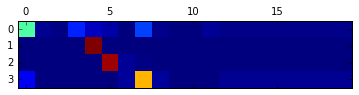

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
1 [20, 807, 2] 高/晓/<EOS> 0.000864102072758 -7.05382 -7.05382 [-2.4955769, -0.0080770999, -4.5501657]


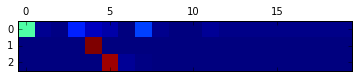

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
2 [84, 2743, 2] 不/懂/<EOS> 0.000437724199309 -7.73392 -7.73392 [-2.4644423, -2.9197059, -2.3497734]


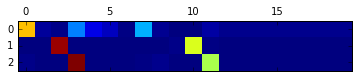

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
3 [1804, 2] 少年/<EOS> 0.000293734168571 -8.13284 -8.13284 [-4.2604895, -3.8723454]


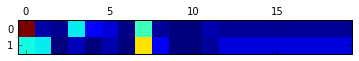

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
4 [1804, 20, 807, 752, 2] 少年/高/晓/松/<EOS> 0.000239001949568 -8.33904 -8.33904 [-4.2604895, -3.5059304, -0.020772174, -0.11563262, -0.43621418]


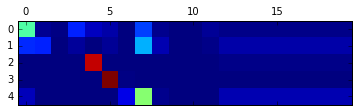

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
5 [84, 2102, 2] 不/再/<EOS> 0.000113799565585 -9.08107 -9.08107 [-2.4644423, -2.7494388, -3.8671904]


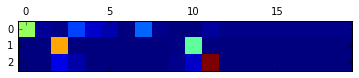

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
6 [20, 807, 752, 1804, 2] 高/晓/松/少年/<EOS> 9.91938706087e-05 -9.21843 -9.21843 [-2.4955769, -0.0080770999, -0.055818126, -6.0496564, -0.60930568]


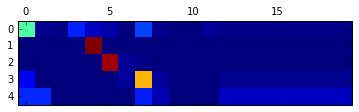

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
7 [752, 2] 松/<EOS> 6.73480508133e-05 -9.60564 -9.60564 [-7.1236982, -2.4819384]


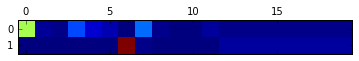

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
8 [807, 752, 2] 晓/松/<EOS> 5.92139699226e-05 -9.73435 -9.73435 [-7.8535132, -1.1275055, -0.75333393]


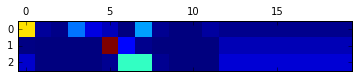

年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
9 [20, 807, 752, 20, 807, 752, 2] 高/晓/松/高/晓/松/<EOS> 5.27967452435e-05 -9.84906 -9.84906 [-2.4955769, -0.0080770999, -0.055818126, -6.1988082, -0.55017173, -0.063822277, -0.4767862]


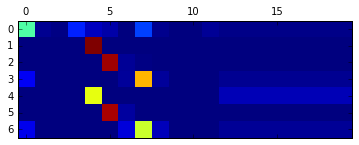

beam search using time(ms): 2295.24302483
word_ids [16898, 84, 124, 639, 1579, 3393, 10617, 982, 8039, 1133, 11347, 13476, 639, 0, 0, 0, 0, 0, 0, 0] len: 20
出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
0 [1579, 2] 英语/<EOS> 0.00486664832519 -5.32535 -5.32535 [-1.9742458, -3.3511038]


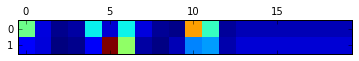

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
1 [1579, 1579, 2] 英语/英语/<EOS> 0.00232957836843 -6.06207 -6.06207 [-1.9742458, -2.3622255, -1.7255967]


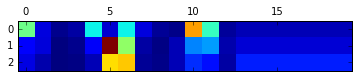

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
2 [84, 124, 639, 2] 不/会/说/<EOS> 0.00192136345716 -6.25472 -6.25472 [-3.8708322, -0.42027426, -0.23741011, -1.726204]


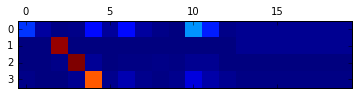

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
3 [84, 124, 639, 1579, 2] 不/会/说/英语/<EOS> 0.00134893430879 -6.60844 -6.60844 [-3.8708322, -0.42027426, -0.23741011, -1.513527, -0.56639713]


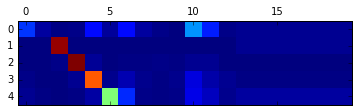

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
4 [639, 1579, 2] 说/英语/<EOS> 0.000766165526182 -7.17411 -7.17411 [-4.3504295, -1.4199423, -1.4037403]


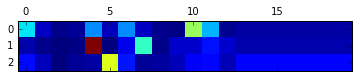

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
5 [16898, 2] 出国/<EOS> 0.000550797813262 -7.50414 -7.50414 [-4.8974628, -2.6066802]


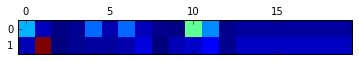

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
6 [11347, 2] 自信/<EOS> 0.000471419864568 -7.65976 -7.65976 [-5.7662754, -1.8934863]


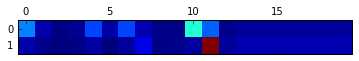

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
7 [639, 2] 说/<EOS> 0.000243116456161 -8.32197 -8.32197 [-4.3504295, -3.9715409]


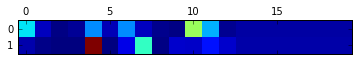

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
8 [16898, 1579, 2] 出国/英语/<EOS> 0.000206440675063 -8.4855 -8.4855 [-4.8974628, -2.6870949, -0.90093982]


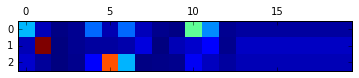

出国/不/会/说/英语/？/每天/5/分钟/，/自信/开口/说
9 [16898, 84, 124, 639, 2] 出国/不/会/说/<EOS> 0.00014506296526 -8.83834 -8.83834 [-4.8974628, -2.2431166, -0.20288053, -0.61485994, -0.88002312]


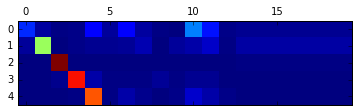

beam search using time(ms): 1519.95921135
word_ids [10113, 15, 6199, 3473, 313, 3110, 5594, 5680, 1133, 1551, 427, 215, 1660, 63037, 316, 0, 0, 0, 0, 0] len: 20
河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
0 [3473, 313, 2] 身份/证/<EOS> 0.0139338564397 -4.27343 -4.27343 [-1.7636789, -0.0032384354, -2.5065165]


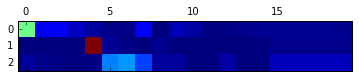

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
1 [5680, 2] 贷款/<EOS> 0.00620119331961 -5.08301 -5.08301 [-2.6155953, -2.4674184]


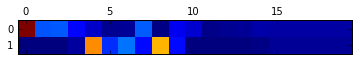

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
2 [5680, 3473, 313, 2] 贷款/身份/证/<EOS> 0.00300207329895 -5.80845 -5.80845 [-2.6155953, -2.4050834, -0.022343911, -0.7654295]


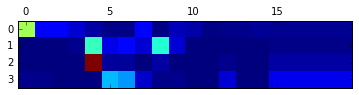

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
3 [5680, 5680, 2] 贷款/贷款/<EOS> 0.00272811006213 -5.90415 -5.90415 [-2.6155953, -1.718353, -1.5701978]


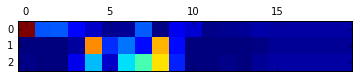

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
4 [10113, 3473, 313, 2] 河源/身份/证/<EOS> 0.000882695461317 -7.03253 -7.03253 [-4.9561143, -1.455868, -0.0021916435, -0.61835605]


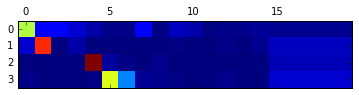

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
5 [5680, 313, 2] 贷款/证/<EOS> 0.000739437384163 -7.20962 -7.20962 [-2.6155953, -3.6392276, -0.95479828]


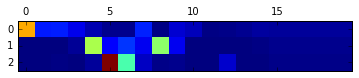

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
6 [10113, 15, 3473, 313, 2] 河源/人/身份/证/<EOS> 0.000608731181926 -7.40413 -7.40413 [-4.9561143, -0.89268523, -1.0303679, -0.0043146377, -0.52065182]


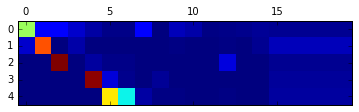

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
7 [5680, 5594, 5680, 2] 贷款/申请/贷款/<EOS> 0.000546979964132 -7.5111 -7.5111 [-2.6155953, -3.1705186, -0.69523865, -1.0297461]


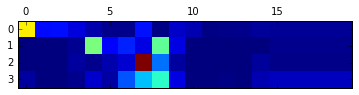

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
8 [3473, 313, 5680, 2] 身份/证/贷款/<EOS> 0.000545410256421 -7.51397 -7.51397 [-1.7636789, -0.0032384354, -4.4147921, -1.3322629]


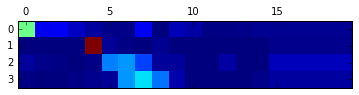

河源/人/凭/身份/证/可以/申请/贷款/，/10/万/月/息/257/元
9 [3473, 313, 3473, 313, 2] 身份/证/身份/证/<EOS> 0.000360193644191 -7.92887 -7.92887 [-1.7636789, -0.0032384354, -4.5650682, -0.034669377, -1.5622139]


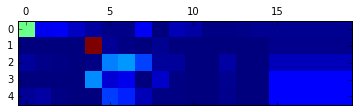

beam search using time(ms): 1512.49504089
word_ids [51, 1582, 235, 14508, 6394, 2089, 5443, 698, 1939, 19373, 1678, 6456, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
0 [6394, 2] 课程/<EOS> 0.00114609941497 -6.77139 -6.77139 [-4.7766509, -1.99474]


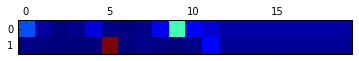

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
1 [1678, 6456, 2] 产品/经理/<EOS> 0.000430536374305 -7.75048 -7.75048 [-4.5197177, -2.1115925, -1.1191684]


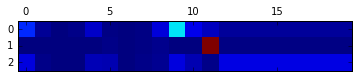

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
2 [19373, 1678, 2] 全能/产品/<EOS> 0.000372890733638 -7.89423 -7.89423 [-5.3425193, -1.8029094, -0.74879652]


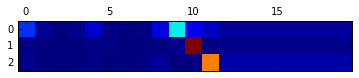

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
3 [1678, 2] 产品/<EOS> 0.000283487482182 -8.16834 -8.16834 [-4.5197177, -3.6486247]


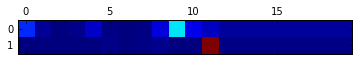

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
4 [19373, 2] 全能/<EOS> 0.000228377844807 -8.38451 -8.38451 [-5.3425193, -3.0419898]


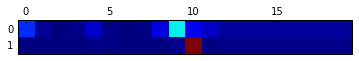

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
5 [6394, 51, 2] 课程/学/<EOS> 3.30053154837e-05 -10.3188 -10.3188 [-4.7766509, -4.3636403, -1.1785504]


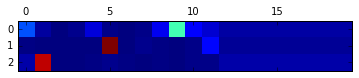

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
6 [1678, 1678, 2] 产品/产品/<EOS> 2.6879438248e-05 -10.5241 -10.5241 [-4.5197177, -4.5854464, -1.4189857]


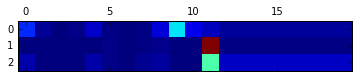

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
7 [6394, 6456, 2] 课程/经理/<EOS> 2.3677174641e-05 -10.651 -10.651 [-4.7766509, -4.7993217, -1.0750263]


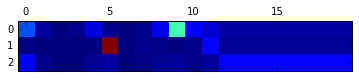

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
8 [6394, 6394, 2] 课程/课程/<EOS> 2.27431836091e-05 -10.6912 -10.6912 [-4.7766509, -4.7123561, -1.202238]


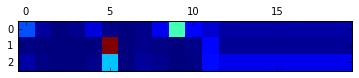

学/完/了/这些/课程/才/知道/什么/叫/全能/产品/经理
9 [51, 1582, 2] 学/完/<EOS> 2.10683161637e-05 -10.7677 -10.7677 [-5.5005178, -3.8198957, -1.447327]


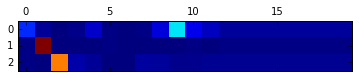

beam search using time(ms): 1730.52310944
word_ids [700, 1161, 14499, 235, 1133, 1428, 1428, 214, 194, 68785, 26997, 210, 4115, 9740, 3393, 0, 0, 0, 0, 0] len: 20
要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
0 [1161, 14499, 2] 考/雅思/<EOS> 0.00113288091395 -6.78299 -6.78299 [-3.5028033, -2.0591803, -1.2210079]


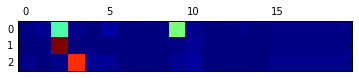

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
1 [14499, 2] 雅思/<EOS> 0.00104863523986 -6.86027 -6.86027 [-4.1454177, -2.7148483]


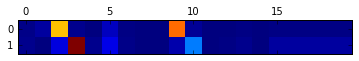

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
2 [1428, 1428, 2] 测/测/<EOS> 0.000568685913354 -7.47218 -7.47218 [-4.8254781, -0.97599256, -1.6707116]


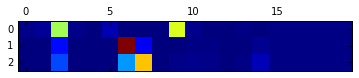

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
3 [1161, 1161, 2] 考/考/<EOS> 0.000349929639452 -7.95778 -7.95778 [-3.5028033, -2.34167, -2.1133051]


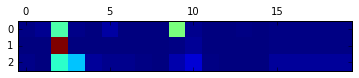

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
4 [1161, 2] 考/<EOS> 0.000234184403717 -8.3594 -8.3594 [-3.5028033, -4.8565979]


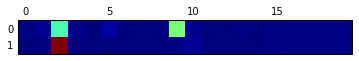

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
5 [1428, 1428, 214, 2] 测/测/你/<EOS> 0.000150913848739 -8.7988 -8.7988 [-4.8254781, -0.97599256, -1.7428275, -1.2545028]


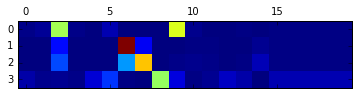

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
6 [1428, 1161, 2] 测/考/<EOS> 4.71335560593e-05 -9.96253 -9.96253 [-4.8254781, -3.5694442, -1.5676035]


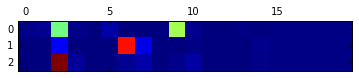

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
7 [214, 2] 你/<EOS> 2.22520673777e-05 -10.7131 -10.7131 [-4.8531537, -5.8599215]


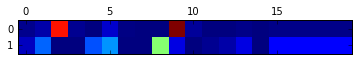

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
8 [700, 1161, 2] 要/考/<EOS> 2.1278031804e-05 -10.7578 -10.7578 [-7.6762037, -0.35683051, -2.7248015]


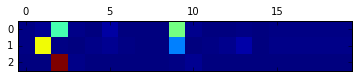

要/考/雅思/了/，/测/测/你/在/考官/眼里/是/啥/水平/？
9 [1161, 214, 2] 考/你/<EOS> 2.00356387549e-05 -10.818 -10.818 [-3.5028033, -4.5900269, -2.725167]


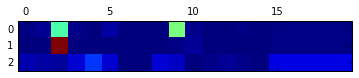

beam search using time(ms): 1530.79080582
word_ids [67, 41, 8330, 4194, 20, 443, 2383, 427, 18920, 1133, 687, 2182, 2949, 8039, 584, 2622, 1133, 1428, 1428, 214] len: 20
最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
0 [67, 41, 8330, 2] 最/新/消息/<EOS> 0.00174254697823 -6.35241 -6.35241 [-3.9291131, -0.09845908, -0.18504034, -2.1397946]


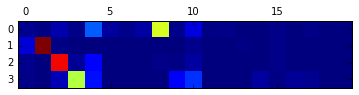

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
1 [20, 443, 2] 高/达/<EOS> 0.00164128111346 -6.41228 -6.41228 [-3.4371755, -0.015524375, -2.9595783]


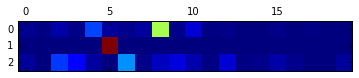

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
2 [18920, 2] 借款/<EOS> 0.000375626519694 -7.88692 -7.88692 [-6.0609617, -1.8259537]


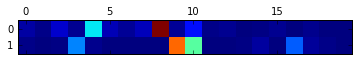

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
3 [20, 443, 67, 41, 8330, 2] 高/达/最/新/消息/<EOS> 0.000125107918261 -8.98633 -8.98633 [-3.4371755, -0.015524375, -4.2212076, -0.11525197, -0.056312133, -1.1408626]


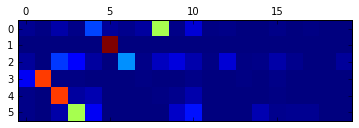

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
4 [8330, 2] 消息/<EOS> 0.000103548609501 -9.17547 -9.17547 [-6.7201824, -2.455287]


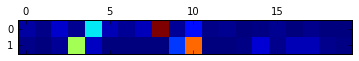

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
5 [2383, 427, 2] 20/万/<EOS> 9.65625699516e-05 -9.24532 -9.24532 [-6.0938807, -0.26089349, -2.8905458]


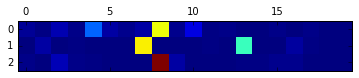

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
6 [67, 41, 8330, 8330, 2] 最/新/消息/消息/<EOS> 3.76795600561e-05 -10.1864 -10.1864 [-3.9291131, -0.09845908, -0.18504034, -4.6782846, -1.2954948]


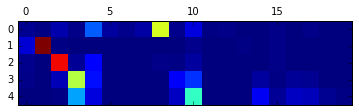

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
7 [2949, 427, 2] 30/万/<EOS> 3.64468329573e-05 -10.2197 -10.2197 [-6.9834976, -0.57558697, -2.6605718]


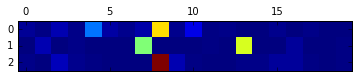

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
8 [41, 8330, 2] 新/消息/<EOS> 2.53442132339e-05 -10.583 -10.583 [-5.82407, -2.6376975, -2.1211934]


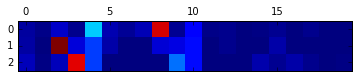

最/新/消息/：/高/达/20/万/借款/，/快/至/30/分钟/到/账/，/测/测/你
9 [67, 20, 8330, 2] 最/高/消息/<EOS> 1.53596304323e-05 -11.0838 -11.0838 [-3.9291131, -4.2903385, -1.3994589, -1.4648567]


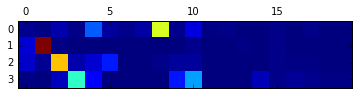

beam search using time(ms): 1523.0050087
word_ids [84, 1059, 9631, 19067, 1133, 12156, 427, 17465, 14211, 1133, 7627, 9, 42964, 1490, 1545, 84, 1545, 3393, 0, 0] len: 20
不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
0 [9631, 2] 社保/<EOS> 0.00353507935593 -5.64502 -5.64502 [-3.1370909, -2.5079286]


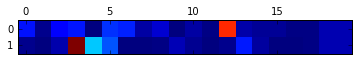

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
1 [84, 1059, 2] 不/限/<EOS> 0.000679387976819 -7.29432 -7.29432 [-3.1187356, -1.6067439, -2.5688388]


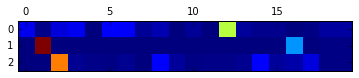

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
2 [9631, 14211, 2] 社保/报销/<EOS> 0.00035858037837 -7.93336 -7.93336 [-3.1370909, -3.5162208, -1.2800461]


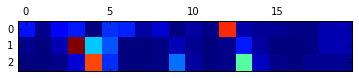

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
3 [14211, 2] 报销/<EOS> 0.000225967002859 -8.39512 -8.39512 [-6.2257605, -2.1693611]


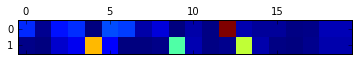

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
4 [19067, 2] 用药/<EOS> 0.000185472723511 -8.5926 -8.5926 [-6.2752676, -2.3173349]


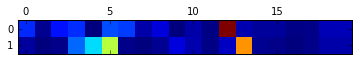

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
5 [1545, 84, 1545, 2] 买/不/买/<EOS> 0.000131498032409 -8.93652 -8.93652 [-5.4050617, -0.54392666, -1.718214, -1.2693161]


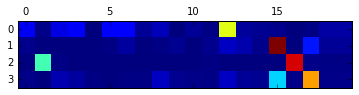

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
6 [84, 1059, 9631, 2] 不/限/社保/<EOS> 6.26176146126e-05 -9.67846 -9.67846 [-3.1187356, -1.6067439, -3.9196031, -1.0333816]


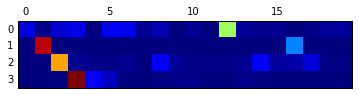

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
7 [9631, 19067, 2] 社保/用药/<EOS> 6.12175000224e-05 -9.70108 -9.70108 [-3.1370909, -5.4456377, -1.1183487]


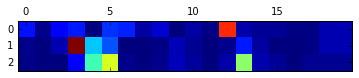

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
8 [84, 14211, 2] 不/报销/<EOS> 5.56833280368e-05 -9.79583 -9.79583 [-3.1187356, -5.4910841, -1.1860105]


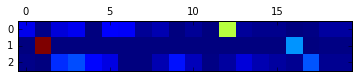

不/限/社保/用药/，/240/万/任性/报销/，/这样/的/防癌/险/买/不/买/？
9 [84, 1059, 1490, 2] 不/限/险/<EOS> 5.41664859513e-05 -9.82345 -9.82345 [-3.1187356, -1.6067439, -3.767946, -1.3300226]


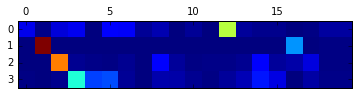

beam search using time(ms): 1543.93410683


In [8]:
#predict(predictor, "宝宝太胖怎么办呢")
#predict(predictor, "包邮买二送一性感女内裤低腰诱惑透视蕾丝露臀大蝴蝶三角内裤女夏-淘宝网")

#predict(predictor, "tensorflow深度学习入门")
#predict(predictor, "大棚辣椒果实变小怎么办,大棚辣椒果实变小防治措施")
#predict(predictor, "土豪邹红建是阿拉斯加")
#predict(predictor, "韩国棒球啦啦队员朴姬兰神似刘亦菲")
#predict(predictor, '你去打篮球')
#predict(predictor, '打篮球你去吗')
#predict(predictor, '这是周华健的新歌爱相随')
#inference('美女劈叉 鼻血狂喷')
#inference('蜀山战纪赵丽颖古装剧照(12张)')
#inference('成龙定制豪车领衔 盘点明星们的奢华定制超跑')
inference('年少不懂高晓松,读懂已不再少年')
#inference('【图】海贼王污图,海贼王白马觉醒,海贼王白马污')
#inference('男生霸气欧美qq欧美头像_“五花八门”')
#inference('美国摄影师拍摄唯美孕妇水下写真艺术照')
#inference('精选高清壁纸：孙俪邓超婚纱照')
#inference('周华健')
#inference('江南女子图片下载')
#inference('英孚英语 出国难开口？每天充电5分钟，真实旅游场景视频课程')
#inference('酷似刘亦菲的朴姬兰')
#inference('酷似朴姬兰的刘亦菲')
inference('出国不会说英语？每天5分钟，自信开口说')
inference('河源人凭身份证可以申请贷款，10万月息257元')
inference('学完了这些课程才知道什么叫全能产品经理')
inference('要考雅思了，测测你在考官眼里是啥水平？')
inference('最新消息：高达20万借款，快至30分钟到账，测测你能借多少')
inference('不限社保用药，240万任性报销，这样的防癌险买不买？')